### <font color='orange'>Importing libraries:</font>

In [ ]:
import numpy as np
from numpy import ones, zeros
import matplotlib.pyplot as plt
from keras.datasets.cifar10 import load_data
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, Conv2DTranspose
from keras.utils.vis_utils import plot_model
from numpy.random import randint, rand, randn
from IPython.display import clear_output, display

Using TensorFlow backend.


### <font color='orange'>Loading cifar10 dataset:</font>

First we load the cifar10 dataset and then summarize the shape of dataset.

In [ ]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

170500096/170498071 [==============================] - 2s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


### <font color='orange'>Plotting 49 images:</font>

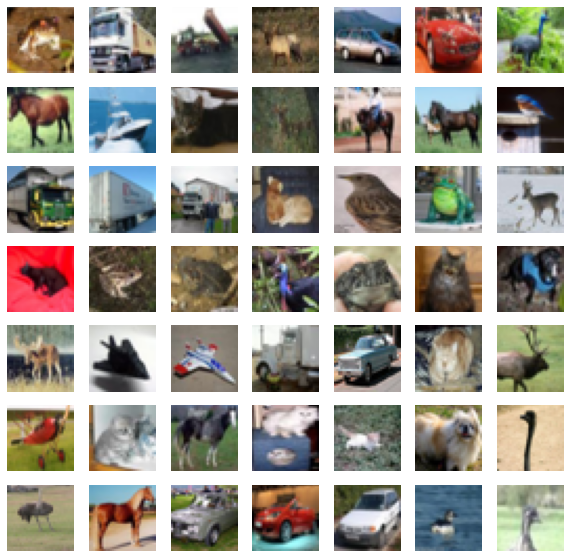

In [ ]:
# plot images from the training dataset
plt.figure(figsize=(10, 10))
for i in range(49):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i])
plt.show()

### <font color='orange'>Creating function to define discriminator:</font>

In [ ]:
# define the function to create and define discriminator
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

### <font color='orange'>Defining discriminator and then visualize the summary:</font>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

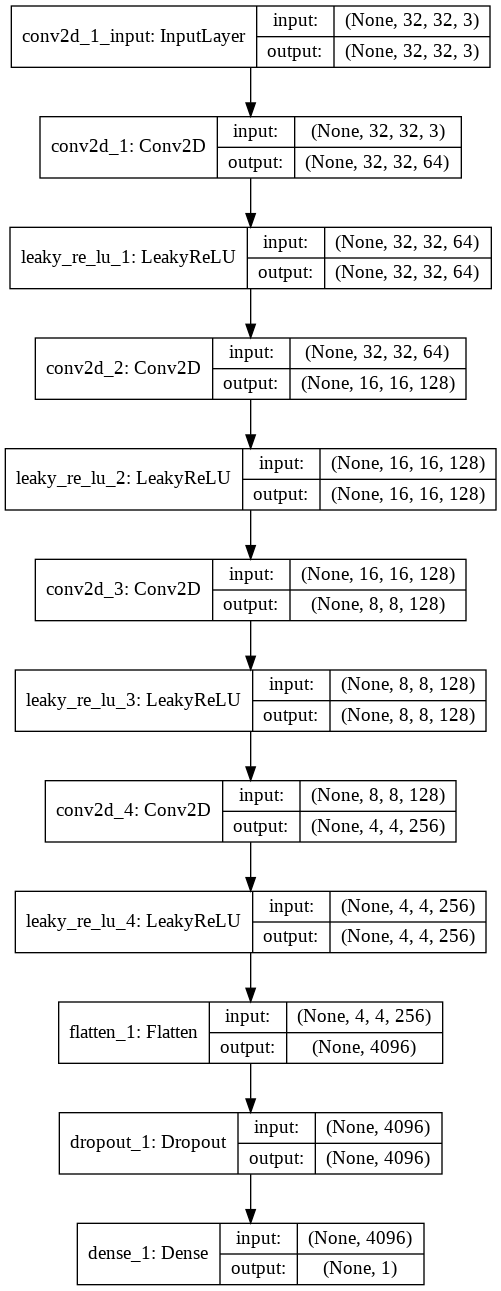

In [ ]:
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

### <font color='orange'>The *load_real_samples()* function below implements the loading and scaling of real CIFAR-10 photographs:</font>

In [ ]:
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

### <font color='orange'>We define two functions to generate real and fake images:</font>

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(32 * 32 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 32, 32, 3))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

###<font color='orange'>Training discriminator:</font>
We implement the *train_discriminator()* function to train discriminator, using a batch size of 128 images, where 64 are real and 64 are fake each iteration.

We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update. This gives insight into how the discriminator model is performing over time.

In [ ]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

>1 real=75% fake=0%
>2 real=98% fake=0%
>3 real=97% fake=17%
>4 real=100% fake=62%
>5 real=89% fake=95%
>6 real=86% fake=98%
>7 real=89% fake=100%
>8 real=89% fake=100%
>9 real=86% fake=100%
>10 real=95% fake=100%
>11 real=98% fake=100%
>12 real=95% fake=100%
>13 real=98% fake=100%
>14 real=98% fake=100%
>15 real=98% fake=100%
>16 real=100% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


## <font color='orange'>Generator:</font>
* <font color='pink'>**Inputs:**</font> Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
* <font color='pink'>**Outputs:**</font> Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1].

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)      

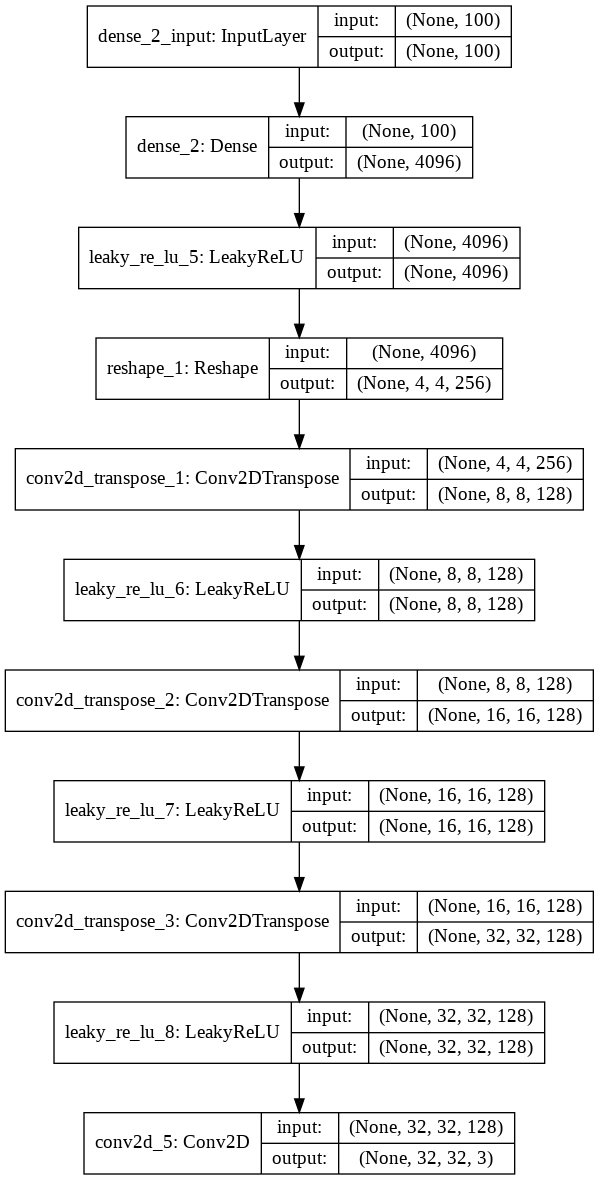

In [ ]:
# define the size of the latent space
latent_dim = 100
# define the generator model
gen_model = define_generator(latent_dim)
# summarize the model
gen_model.summary()
# plot the model
plot_model(gen_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

### <font color='orange'>Defining functions *generate_latent_points* and *generate_fake_samples*:</font>

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

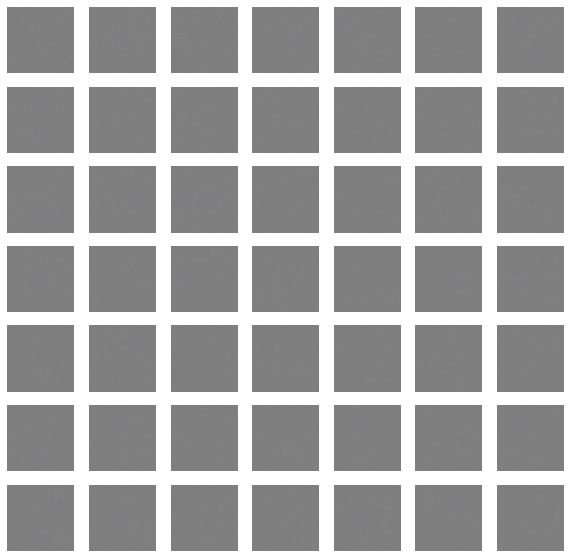

In [ ]:
# size of the latent space
plt.figure(figsize=(10, 10))
latent_dim = 100
# generate samples
n_samples = 49
X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i])
# show the figure
plt.show()

The define_gan() function below takes as arguments the already-defined generator and discriminator models and creates the new, logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

### <font color='orange'>creating the discriminator, generator and composite model:</font>

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


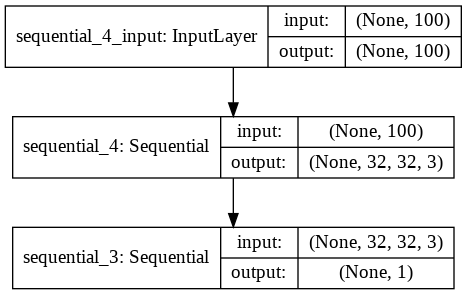

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

There are a few things to note in this model training function.

First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 50K samples, so with rounding down, there are 390 batches per epoch.

The discriminator model is updated twice per batch, once with real samples and once with fake samples, which is a best practice as opposed to combining the samples and performing a single update.

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch. The generator loss is less critical and may hover between 0.5 and 2 or higher. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	fig = plt.figure(figsize=(n, n))
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	#plt.close()
	plt.show()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=300):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
	return acc_real, acc_fake

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	dis_loss = np.zeros(bat_per_epo * n_epochs)
	gen_loss = np.zeros(bat_per_epo * n_epochs)
	half_batch = int(n_batch / 2)
	accuracy_real = np.zeros(n_epochs)
	accuracy_fake = np.zeros(n_epochs)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# Sum of two losses
			d_loss_tot = d_loss1 + d_loss2
			dis_loss[i*bat_per_epo+j] = d_loss_tot
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			gen_loss[i*bat_per_epo+j] = g_loss
			# summarize loss on this batch
			#if (i+1) % 10 == 0:
		print('epoch %d finished, batch: (%d/%d), d_loss=%.3f, g_loss=%.3f'%
			(i+1, j+1, bat_per_epo, d_loss_tot, g_loss))
		if i % 20 == 0:
			acc_real, acc_fake = summarize_performance(i, g_model, d_model, dataset, latent_dim)
			accuracy_real[i] = acc_real
			accuracy_fake[i] = acc_fake
	acc_real, acc_fake = summarize_performance(i, g_model, d_model, dataset, latent_dim)
	accuracy_real[i] = acc_real
	accuracy_fake[i] = acc_fake
	return dis_loss, gen_loss, accuracy_real, accuracy_fake

<font color='orange'>Training and plotting $10\times 10$ images in different epochs to show the progress of training:</font>

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 1 finished, batch: (390/390), d_loss=0.809, g_loss=1.568
Accuracy real: 69%, fake: 92%


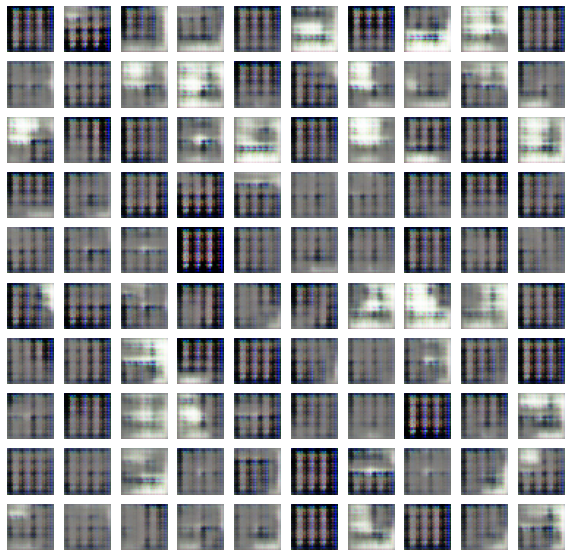

epoch 2 finished, batch: (390/390), d_loss=1.040, g_loss=1.843
epoch 3 finished, batch: (390/390), d_loss=1.172, g_loss=1.159
epoch 4 finished, batch: (390/390), d_loss=1.335, g_loss=1.073
epoch 5 finished, batch: (390/390), d_loss=0.703, g_loss=1.573
epoch 6 finished, batch: (390/390), d_loss=1.166, g_loss=1.237
epoch 7 finished, batch: (390/390), d_loss=1.160, g_loss=1.132
epoch 8 finished, batch: (390/390), d_loss=1.109, g_loss=1.255
epoch 9 finished, batch: (390/390), d_loss=1.236, g_loss=1.288
epoch 10 finished, batch: (390/390), d_loss=1.228, g_loss=1.101
epoch 11 finished, batch: (390/390), d_loss=1.233, g_loss=1.141
epoch 12 finished, batch: (390/390), d_loss=1.389, g_loss=0.888
epoch 13 finished, batch: (390/390), d_loss=1.250, g_loss=0.850
epoch 14 finished, batch: (390/390), d_loss=1.431, g_loss=0.874
epoch 15 finished, batch: (390/390), d_loss=1.325, g_loss=0.841
epoch 16 finished, batch: (390/390), d_loss=1.316, g_loss=0.873
epoch 17 finished, batch: (390/390), d_loss=1.24

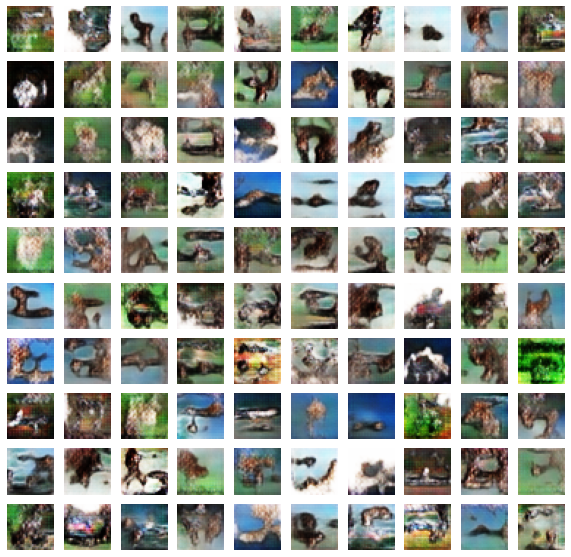

epoch 22 finished, batch: (390/390), d_loss=1.309, g_loss=0.873
epoch 23 finished, batch: (390/390), d_loss=1.362, g_loss=0.836
epoch 24 finished, batch: (390/390), d_loss=1.295, g_loss=0.829
epoch 25 finished, batch: (390/390), d_loss=1.308, g_loss=0.837
epoch 26 finished, batch: (390/390), d_loss=1.355, g_loss=0.859
epoch 27 finished, batch: (390/390), d_loss=1.311, g_loss=0.911
epoch 28 finished, batch: (390/390), d_loss=1.308, g_loss=0.808
epoch 29 finished, batch: (390/390), d_loss=1.310, g_loss=0.841
epoch 30 finished, batch: (390/390), d_loss=1.266, g_loss=0.800
epoch 31 finished, batch: (390/390), d_loss=1.315, g_loss=0.943
epoch 32 finished, batch: (390/390), d_loss=1.291, g_loss=0.842
epoch 33 finished, batch: (390/390), d_loss=1.306, g_loss=0.781
epoch 34 finished, batch: (390/390), d_loss=1.326, g_loss=0.829
epoch 35 finished, batch: (390/390), d_loss=1.296, g_loss=0.806
epoch 36 finished, batch: (390/390), d_loss=1.242, g_loss=0.817
epoch 37 finished, batch: (390/390), d_l

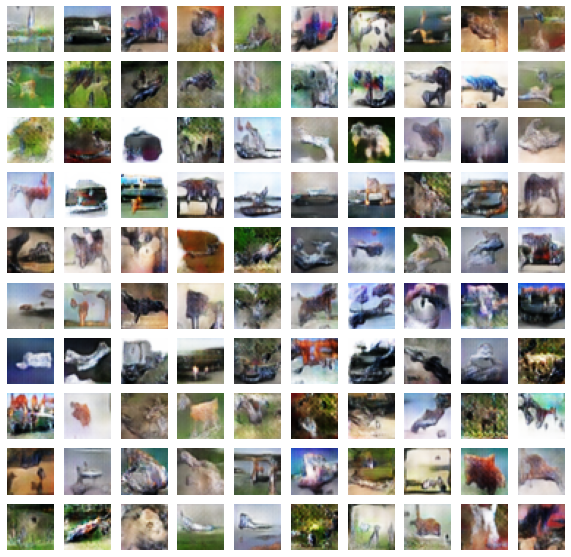

epoch 42 finished, batch: (390/390), d_loss=1.378, g_loss=0.837
epoch 43 finished, batch: (390/390), d_loss=1.271, g_loss=0.834
epoch 44 finished, batch: (390/390), d_loss=1.360, g_loss=0.821
epoch 45 finished, batch: (390/390), d_loss=1.308, g_loss=0.879
epoch 46 finished, batch: (390/390), d_loss=1.252, g_loss=0.804
epoch 47 finished, batch: (390/390), d_loss=1.331, g_loss=0.859
epoch 48 finished, batch: (390/390), d_loss=1.293, g_loss=0.871
epoch 49 finished, batch: (390/390), d_loss=1.453, g_loss=0.897
epoch 50 finished, batch: (390/390), d_loss=1.373, g_loss=0.786
epoch 51 finished, batch: (390/390), d_loss=1.338, g_loss=0.856
epoch 52 finished, batch: (390/390), d_loss=1.253, g_loss=0.879
epoch 53 finished, batch: (390/390), d_loss=1.327, g_loss=0.824
epoch 54 finished, batch: (390/390), d_loss=1.347, g_loss=0.819
epoch 55 finished, batch: (390/390), d_loss=1.242, g_loss=0.841
epoch 56 finished, batch: (390/390), d_loss=1.232, g_loss=0.869
epoch 57 finished, batch: (390/390), d_l

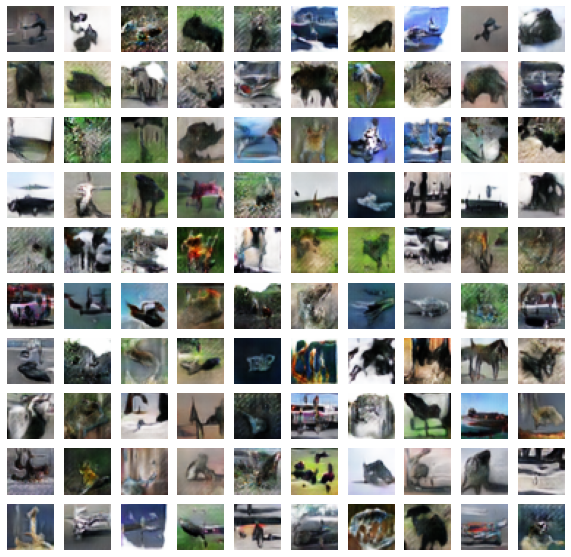

epoch 62 finished, batch: (390/390), d_loss=1.290, g_loss=0.902
epoch 63 finished, batch: (390/390), d_loss=1.264, g_loss=0.892
epoch 64 finished, batch: (390/390), d_loss=1.186, g_loss=0.898
epoch 65 finished, batch: (390/390), d_loss=1.309, g_loss=0.936
epoch 66 finished, batch: (390/390), d_loss=1.251, g_loss=0.855
epoch 67 finished, batch: (390/390), d_loss=1.252, g_loss=0.877
epoch 68 finished, batch: (390/390), d_loss=1.288, g_loss=0.884
epoch 69 finished, batch: (390/390), d_loss=1.271, g_loss=0.860
epoch 70 finished, batch: (390/390), d_loss=1.252, g_loss=0.884
epoch 71 finished, batch: (390/390), d_loss=1.341, g_loss=0.902
epoch 72 finished, batch: (390/390), d_loss=1.158, g_loss=0.967
epoch 73 finished, batch: (390/390), d_loss=1.161, g_loss=0.914
epoch 74 finished, batch: (390/390), d_loss=1.315, g_loss=0.893
epoch 75 finished, batch: (390/390), d_loss=1.260, g_loss=1.027
epoch 76 finished, batch: (390/390), d_loss=1.263, g_loss=0.828
epoch 77 finished, batch: (390/390), d_l

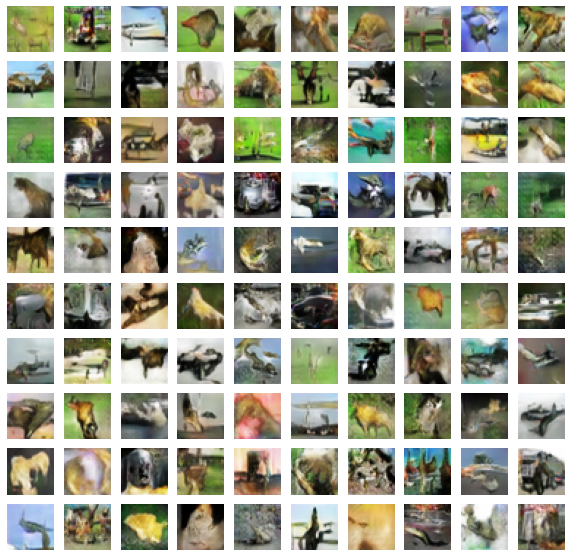

epoch 82 finished, batch: (390/390), d_loss=1.429, g_loss=0.865
epoch 83 finished, batch: (390/390), d_loss=1.249, g_loss=0.969
epoch 84 finished, batch: (390/390), d_loss=1.264, g_loss=0.862
epoch 85 finished, batch: (390/390), d_loss=1.266, g_loss=0.878
epoch 86 finished, batch: (390/390), d_loss=1.309, g_loss=1.034
epoch 87 finished, batch: (390/390), d_loss=1.305, g_loss=0.965
epoch 88 finished, batch: (390/390), d_loss=1.207, g_loss=0.922
epoch 89 finished, batch: (390/390), d_loss=1.262, g_loss=1.043
epoch 90 finished, batch: (390/390), d_loss=1.318, g_loss=0.864
epoch 91 finished, batch: (390/390), d_loss=1.293, g_loss=0.942
epoch 92 finished, batch: (390/390), d_loss=1.251, g_loss=0.923
epoch 93 finished, batch: (390/390), d_loss=1.256, g_loss=0.990
epoch 94 finished, batch: (390/390), d_loss=1.168, g_loss=0.992
epoch 95 finished, batch: (390/390), d_loss=1.313, g_loss=0.962
epoch 96 finished, batch: (390/390), d_loss=1.276, g_loss=1.075
epoch 97 finished, batch: (390/390), d_l

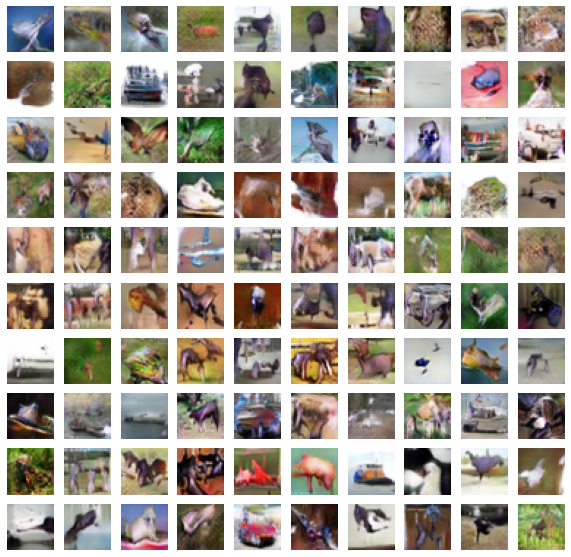

epoch 102 finished, batch: (390/390), d_loss=1.253, g_loss=0.958
epoch 103 finished, batch: (390/390), d_loss=1.196, g_loss=1.049
epoch 104 finished, batch: (390/390), d_loss=1.203, g_loss=0.997
epoch 105 finished, batch: (390/390), d_loss=1.226, g_loss=1.063
epoch 106 finished, batch: (390/390), d_loss=1.188, g_loss=1.101
epoch 107 finished, batch: (390/390), d_loss=1.113, g_loss=1.008
epoch 108 finished, batch: (390/390), d_loss=1.188, g_loss=1.006
epoch 109 finished, batch: (390/390), d_loss=1.258, g_loss=0.987
epoch 110 finished, batch: (390/390), d_loss=1.055, g_loss=1.219
epoch 111 finished, batch: (390/390), d_loss=1.146, g_loss=0.963
epoch 112 finished, batch: (390/390), d_loss=1.230, g_loss=1.050
epoch 113 finished, batch: (390/390), d_loss=1.156, g_loss=1.023
epoch 114 finished, batch: (390/390), d_loss=1.287, g_loss=1.104
epoch 115 finished, batch: (390/390), d_loss=1.306, g_loss=1.023
epoch 116 finished, batch: (390/390), d_loss=1.228, g_loss=1.039
epoch 117 finished, batch

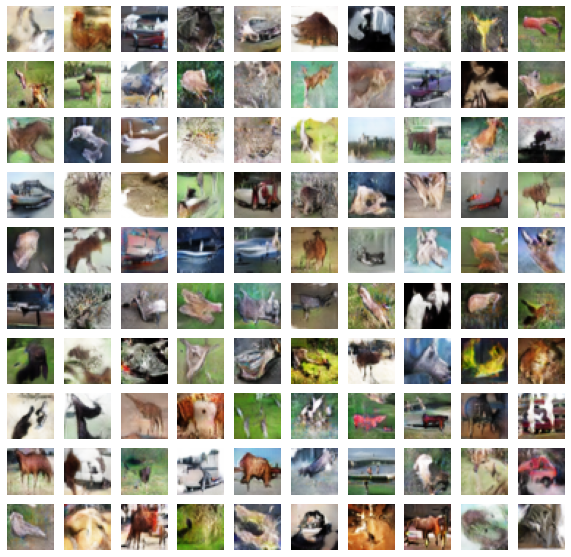

epoch 122 finished, batch: (390/390), d_loss=1.109, g_loss=1.125
epoch 123 finished, batch: (390/390), d_loss=1.185, g_loss=1.045
epoch 124 finished, batch: (390/390), d_loss=1.101, g_loss=1.088
epoch 125 finished, batch: (390/390), d_loss=1.265, g_loss=1.059
epoch 126 finished, batch: (390/390), d_loss=1.153, g_loss=1.098
epoch 127 finished, batch: (390/390), d_loss=1.196, g_loss=1.043
epoch 128 finished, batch: (390/390), d_loss=1.147, g_loss=1.056
epoch 129 finished, batch: (390/390), d_loss=1.184, g_loss=1.052
epoch 130 finished, batch: (390/390), d_loss=1.113, g_loss=1.066
epoch 131 finished, batch: (390/390), d_loss=1.150, g_loss=1.170
epoch 132 finished, batch: (390/390), d_loss=1.192, g_loss=0.998
epoch 133 finished, batch: (390/390), d_loss=1.175, g_loss=1.099
epoch 134 finished, batch: (390/390), d_loss=1.171, g_loss=1.053
epoch 135 finished, batch: (390/390), d_loss=1.088, g_loss=1.103
epoch 136 finished, batch: (390/390), d_loss=1.295, g_loss=1.094
epoch 137 finished, batch

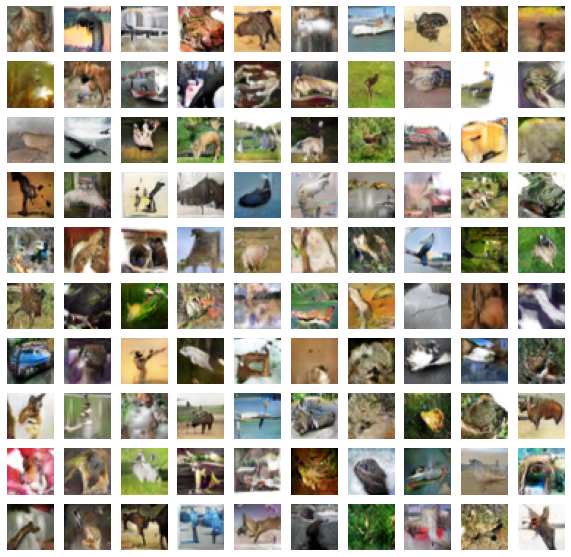

epoch 142 finished, batch: (390/390), d_loss=1.072, g_loss=1.166
epoch 143 finished, batch: (390/390), d_loss=1.112, g_loss=1.126
epoch 144 finished, batch: (390/390), d_loss=1.113, g_loss=1.168
epoch 145 finished, batch: (390/390), d_loss=1.233, g_loss=1.166
epoch 146 finished, batch: (390/390), d_loss=1.100, g_loss=1.173
epoch 147 finished, batch: (390/390), d_loss=1.256, g_loss=1.181
epoch 148 finished, batch: (390/390), d_loss=1.218, g_loss=1.179
epoch 149 finished, batch: (390/390), d_loss=1.308, g_loss=1.185
epoch 150 finished, batch: (390/390), d_loss=1.127, g_loss=1.119
epoch 151 finished, batch: (390/390), d_loss=1.183, g_loss=1.297
epoch 152 finished, batch: (390/390), d_loss=1.095, g_loss=1.245
epoch 153 finished, batch: (390/390), d_loss=1.265, g_loss=1.146
epoch 154 finished, batch: (390/390), d_loss=1.099, g_loss=1.181
epoch 155 finished, batch: (390/390), d_loss=1.104, g_loss=1.104
epoch 156 finished, batch: (390/390), d_loss=1.165, g_loss=1.173
epoch 157 finished, batch

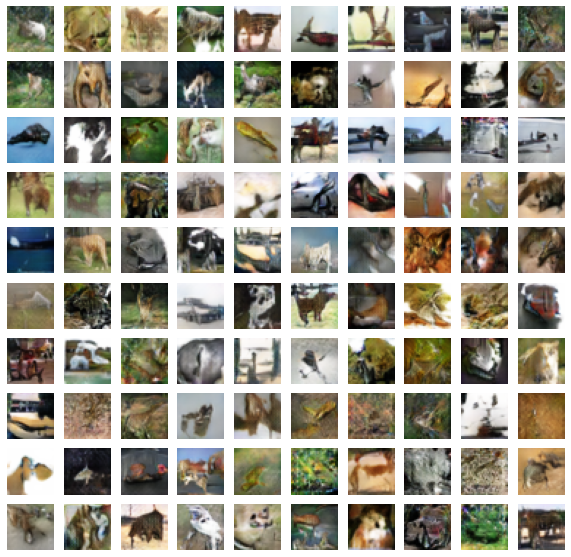

epoch 162 finished, batch: (390/390), d_loss=1.053, g_loss=1.207
epoch 163 finished, batch: (390/390), d_loss=1.274, g_loss=1.115
epoch 164 finished, batch: (390/390), d_loss=1.276, g_loss=1.161
epoch 165 finished, batch: (390/390), d_loss=1.185, g_loss=1.155
epoch 166 finished, batch: (390/390), d_loss=1.197, g_loss=1.188
epoch 167 finished, batch: (390/390), d_loss=1.056, g_loss=1.172
epoch 168 finished, batch: (390/390), d_loss=1.228, g_loss=1.220
epoch 169 finished, batch: (390/390), d_loss=1.149, g_loss=1.136
epoch 170 finished, batch: (390/390), d_loss=1.205, g_loss=1.259
epoch 171 finished, batch: (390/390), d_loss=1.053, g_loss=1.122
epoch 172 finished, batch: (390/390), d_loss=1.158, g_loss=1.255
epoch 173 finished, batch: (390/390), d_loss=1.018, g_loss=1.300
epoch 174 finished, batch: (390/390), d_loss=1.185, g_loss=1.137
epoch 175 finished, batch: (390/390), d_loss=1.185, g_loss=1.260
epoch 176 finished, batch: (390/390), d_loss=1.042, g_loss=1.183
epoch 177 finished, batch

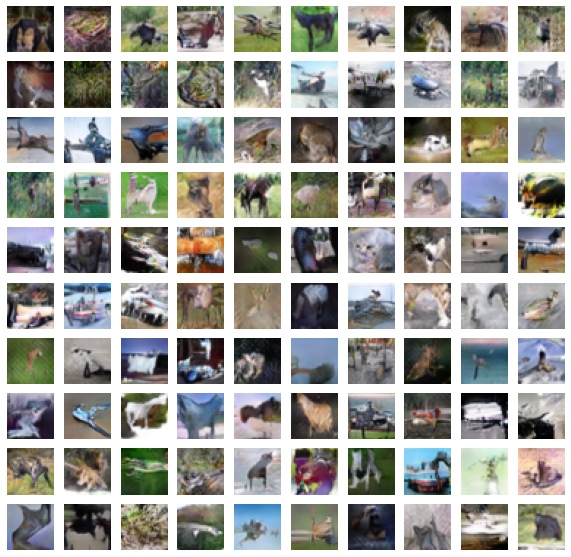

epoch 182 finished, batch: (390/390), d_loss=1.171, g_loss=1.334
epoch 183 finished, batch: (390/390), d_loss=1.040, g_loss=1.085
epoch 184 finished, batch: (390/390), d_loss=1.102, g_loss=1.129
epoch 185 finished, batch: (390/390), d_loss=1.107, g_loss=1.261
epoch 186 finished, batch: (390/390), d_loss=1.134, g_loss=1.281
epoch 187 finished, batch: (390/390), d_loss=1.078, g_loss=1.288
epoch 188 finished, batch: (390/390), d_loss=0.990, g_loss=1.177
epoch 189 finished, batch: (390/390), d_loss=1.169, g_loss=1.130
epoch 190 finished, batch: (390/390), d_loss=1.008, g_loss=1.271
epoch 191 finished, batch: (390/390), d_loss=0.907, g_loss=1.195
epoch 192 finished, batch: (390/390), d_loss=1.036, g_loss=1.179
epoch 193 finished, batch: (390/390), d_loss=1.087, g_loss=1.252
epoch 194 finished, batch: (390/390), d_loss=1.020, g_loss=1.365
epoch 195 finished, batch: (390/390), d_loss=1.260, g_loss=1.311
epoch 196 finished, batch: (390/390), d_loss=0.986, g_loss=1.282
epoch 197 finished, batch

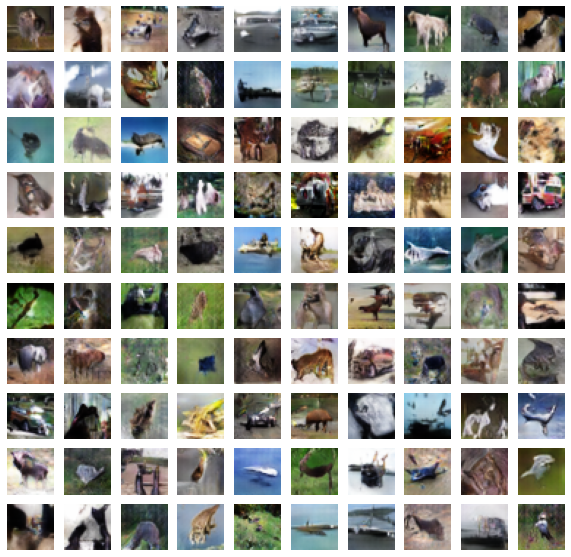

In [ ]:
n_epochs = 200
n_batch = 128
# train model
dis_loss, gen_loss, accuracy_real, accuracy_fake = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

Text(0.5, 1.0, "DCGAN Model discriminator and generator's Loss")

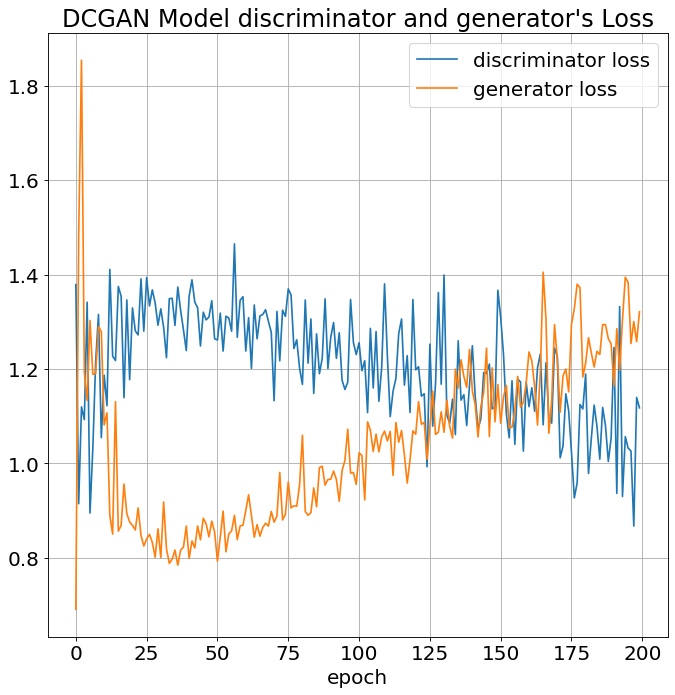

In [ ]:
plot_range = np.arange(200)*390
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(dis_loss[plot_range], label="discriminator loss")
plt.plot(gen_loss[plot_range], label="generator loss")
plt.grid('on')
plt.legend()
plt.xlabel("epoch")
plt.title('DCGAN Model discriminator and generator\'s Loss')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


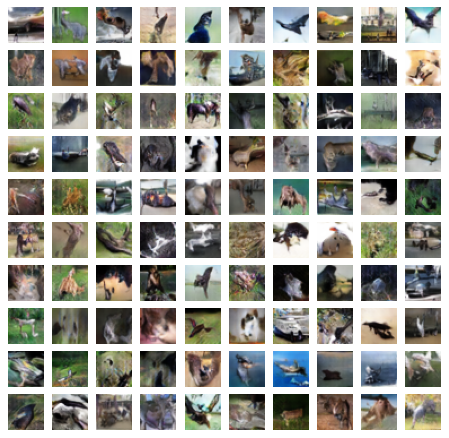

In [ ]:
from keras.models import load_model
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# plot the generated images
def create_plot(examples, n):
    plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='w')
	# plot images
    for i in range(n * n):
		# define subplot
        plt.subplot(n, n, 1 + i)
		# turn off axis
        plt.axis('off')
		# plot raw pixel data
        plt.imshow(examples[i, :, :])
    #plt.title("Generating 100 images")
    plt.show()
 
# load model
model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


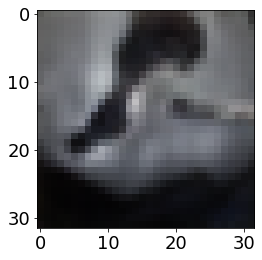

In [ ]:
# example of generating an image for a specific point in the latent space
from numpy import asarray

# load model
model = load_model('generator_model_200.h5')
# all 0s
vector = asarray([[0.7 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plt.imshow(X[0, :, :])
plt.show()